<a href="https://colab.research.google.com/github/Shri-Aiswarya/NLP/blob/main/NLP_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exercise 1. Sentiment Analysis
This exercise will allow you to use PyTorch. Refer to the DATA 690 Resources.
1. Import the required libraries.

In [35]:
#Importing the required libraries
!pip install torch

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

2. Load the dataset containing a set of 1,000 product reviews from Amazon, which are
paired with a label of 0 (for negative reviews) or 1 (for positive reviews). Get the data at
https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences.

In [36]:
#Loading the dataset and rename columns
dataset = pd.read_csv('amazon_cells_labelled.txt', delimiter='\t', header=None, names=['review', 'label'])
dataset.head()

,review,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


3. Separate the data into two variables: one containing the reviews and the other containing
the labels. Remove the punctuation from the reviews.

In [37]:
#Separating the data into two variables
#Removing punctuation
dataset['review'] = dataset['review'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
#Separating the reviews and labels
reviews = dataset['review'].values
labels = dataset['label'].values

4. Create a variable containing the vocabulary of the entire set of reviews.

In [38]:
#Tokenizing the reviews
vocabulary = set()
for review in reviews:
    words = review.split()
    vocabulary.update(words)
vocabulary = list(vocabulary)

print(f'Vocabulary Size: {len(vocabulary)}')

Vocabulary Size: 2220


5.  Additionally, create a dictionary that maps each word to an integer, where the words will be the keys and the integers will be the values.

In [40]:
#Creating a word-to-integer dictionary
word_to_int = {word: idx for idx, word in enumerate(vocabulary)}
print(f"Example mapping: {list(word_to_int.items())[:5]}")

Example mapping: [('three', 0), ('scary', 1), ('bad', 2), ('graphics', 3), ('Truly', 4)]


6. Encode the review data by replacing each word in a review for its paired integer.


In [41]:
#Encoding each review into integers
encoded_reviews = [[word_to_int[word] for word in review.split() if word in word_to_int] for review in reviews]

#Padding all reviews to the same length
max_len = max(len(review) for review in encoded_reviews)
encoded_reviews = [review + [0]*(max_len - len(review)) for review in encoded_reviews]
encoded_reviews = np.array(encoded_reviews)

print(f"Encoded reviews shape: {encoded_reviews.shape}")

Encoded reviews shape: (1000, 30)


7. Create a class containing the architecture of the network.


In [42]:
#Defining the Model Architecture
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, lstm_hidden_size, output_size, n_layers=3):
        """
        Initialize the SentimentLSTM model.
        Args:
        - vocab_size (int): The size of the vocabulary (number of unique words).
        - embedding_dim (int): The number of dimensions in the word embeddings.
        - lstm_hidden_size (int): The number of neurons in the LSTM hidden layers.
        - output_size (int): The size of the output (1 for binary classification).
        - n_layers (int): The number of LSTM layers (default is 3).
        """
        super(SentimentLSTM, self).__init__()

        # Embedding layer that converts words into dense vectors of fixed size (embedding_dim).
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layers with 'n_layers' stacked LSTM cells.
        # batch_first=True means that the input/output tensors will have the shape (batch_size, seq_length, input_size).
        self.lstm = nn.LSTM(embedding_dim, lstm_hidden_size, n_layers, batch_first=True)

        # Fully connected (dense) layer that maps LSTM outputs to a single output value.
        self.fc = nn.Linear(lstm_hidden_size, output_size)

        # Sigmoid activation to output probabilities for binary classification (between 0 and 1).
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Perform a forward pass through the network.
        Args:
        - x (tensor): Input tensor of tokenized reviews (batch_size, seq_length).
        Returns:
        - tensor: A tensor containing the predicted sentiment scores (between 0 and 1).
        """
        # Pass input through the embedding layer to get the word embeddings.
        embedded = self.embedding(x)

        # Pass the embeddings through the LSTM layers.
        # lstm_out contains all hidden states in the sequence, while _ contains the last hidden state and cell state.
        lstm_out, _ = self.lstm(embedded)

        # Take the hidden state of the last LSTM time step (last word in the sequence).
        out = lstm_out[:, -1, :]

        # Pass the last hidden state through the fully connected layer.
        out = self.fc(out)

        # Apply sigmoid activation to get the final probability score (0 to 1).
        return self.sigmoid(out)


8. Make sure that you include an embedding layer. Initialize the model using 64 embedding
dimensions and 128 neurons for 3 LSTM layers.

In [43]:
#Initializing the Model
#Calculating the size of the vocabulary (number of unique words in the dataset).
vocab_size = len(vocabulary)
embedding_dim = 64
lstm_hidden_size = 128
output_size = 1
#Instantiating the SentimentLSTM model with the specified parameters.
model = SentimentLSTM(vocab_size, embedding_dim, lstm_hidden_size, output_size)
print(model)

SentimentLSTM(
  (embedding): Embedding(2220, 64)
  (lstm): LSTM(64, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


9. Define the loss function, an optimization algorithm, and the number of epochs to train for.
For example, you can use binary cross-entropy loss as the loss function, the Adam
optimizer, and train for 10 epochs.

In [44]:
#Defining the Loss Function, Optimizer, and Number of Epochs
#Binary Cross Entropy Loss
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

10. Create a for loop that goes through the different epochs and through every single review individually. For each review, perform a prediction, calculate the loss function, and
update the parameters of the network. Additionally, calculate the accuracy of the network
over that training data.

In [45]:
#Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(encoded_reviews, labels, test_size=0.2)

#Converting to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

#Creating a DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

#Training loop
train_losses, accuracies = [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    y_preds, y_trues = [], []

    for reviews_batch, labels_batch in train_loader:
        optimizer.zero_grad()
        output = model(reviews_batch)
        loss = loss_function(output, labels_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        #Calculating accuracy
        predictions = (output > 0.5).float()
        y_preds.extend(predictions.detach().cpu().numpy())
        y_trues.extend(labels_batch.cpu().numpy())

    epoch_accuracy = accuracy_score(y_trues, y_preds)
    train_losses.append(total_loss / len(train_loader))
    accuracies.append(epoch_accuracy)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}")


Epoch 1/10, Loss: 0.6951, Accuracy: 0.4938
Epoch 2/10, Loss: 0.6938, Accuracy: 0.4637
Epoch 3/10, Loss: 0.6933, Accuracy: 0.4963
Epoch 4/10, Loss: 0.6933, Accuracy: 0.4825
Epoch 5/10, Loss: 0.6931, Accuracy: 0.5062
Epoch 6/10, Loss: 0.6934, Accuracy: 0.5012
Epoch 7/10, Loss: 0.6932, Accuracy: 0.5012
Epoch 8/10, Loss: 0.6929, Accuracy: 0.5150
Epoch 9/10, Loss: 0.6931, Accuracy: 0.5050
Epoch 10/10, Loss: 0.6906, Accuracy: 0.5200


11. Plot the progress of the loss function and accuracy over time.

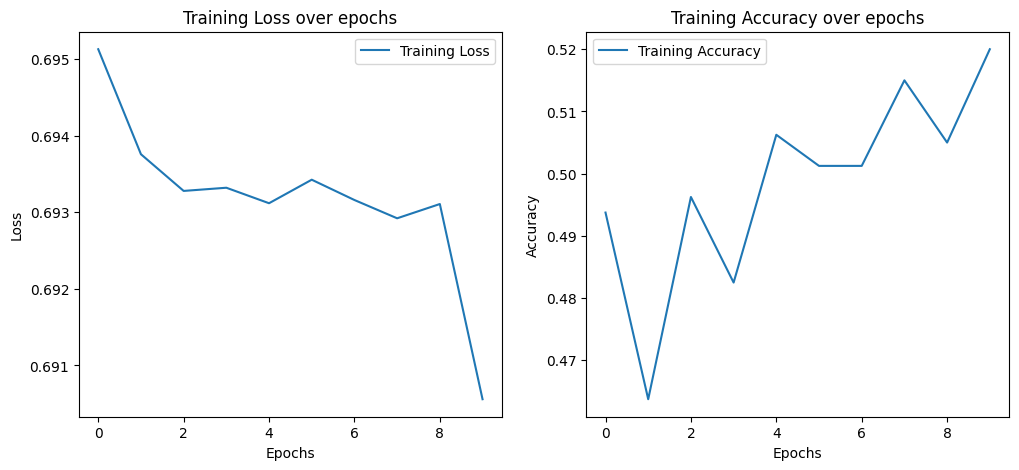

In [46]:
#Plotting the Loss and Accuracy over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy')
plt.title('Training Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Exercise 2. Sentiment Analysis

Consider the following text:

sentence = “””The larger Broncos will be available with 35-inch off-road tires and will be able
to drive through water nearly 3 feet, 10 inches deep. It has independent front suspension, unlike its main competitor, the Jeep Wrangler. Independent suspension, used
on almost all modern passenger vehicles, generally provides a smoother ride and better on -
road handling than a single solid axle. It still has a solid axle in the back though, like most
pickup trucks, a design suited to hard use. Like the Wrangler, both the two- and four-door
Bronco will have a removable roofs and doors. Buyers will be able to choose either a hard
roof that can be removed in sections, a cloth top, or both. Unlike the Wrangler, though, the
Bronco's doors will fit inside the vehicle after being removed. The Bronco will be available
with a choice of either a 10-speed automatic or seven-speed manual transmission. (The
manual transmission will have six gears for ordinary driving, plus a seventh for low speed
off-road driving.) It will be powered by either a 270- horsepower 2.3-liter turbocharged 4-
cylinder engine or a 310-horsepower 2.7-liter turbocharged V6. While all of the new Bronco
SUVs are designed for hard off-road use, the Bronco Sport isn't quite as hard-core in its
capabilities. It also has more convenience features than the more truck-like Bronco. While
it's based on engineering that's similar to car-like crossover SUVs, Ford says that it's still
intended for serious off-road use. Ford engineers boasted of the off-road testing the
prototypes have been put through, including driving through deep sand, up steep inclines ,
and crawling across boulder-strewn trails.”””
Perform the following task on the above sentences:

1. Replace special characters with empty spaces. You can use regex or any other method

In [47]:
!pip install TextBlob nltk

In [48]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from textblob import TextBlob
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
sentence = """The larger Broncos will be available with 35-inch off-road tires and will be able
to drive through water nearly 3 feet, 10 inches deep. It has independent front DATA 690 2
suspension, unlike its main competitor, the Jeep Wrangler. Independent suspension, used
on almost all modern passenger vehicles, generally provides a smoother ride and better on -
road handling than a single solid axle. It still has a solid axle in the back though, like most
pickup trucks, a design suited to hard use. Like the Wrangler, both the two- and four-door
Bronco will have a removable roofs and doors. Buyers will be able to choose either a hard
roof that can be removed in sections, a cloth top, or both. Unlike the Wrangler, though, the
Bronco's doors will fit inside the vehicle after being removed. The Bronco will be available
with a choice of either a 10-speed automatic or seven-speed manual transmission. (The
manual transmission will have six gears for ordinary driving, plus a seventh for low speed
off-road driving.) It will be powered by either a 270- horsepower 2.3-liter turbocharged 4-
cylinder engine or a 310-horsepower 2.7-liter turbocharged V6. While all of the new Bronco
SUVs are designed for hard off-road use, the Bronco Sport isn't quite as hard-core in its
capabilities. It also has more convenience features than the more truck-like Bronco. While
it's based on engineering that's similar to car-like crossover SUVs, Ford says that it's still
intended for serious off-road use. Ford engineers boasted of the off-road testing the
prototypes have been put through, including driving through deep sand, up steep inclines ,
and crawling across boulder-strewn trails."""

In [49]:
#Replacing characters with empty spaces
cleaned_text = re.sub(r'[^\w\s]', ' ', sentence)

2. Remove multiple empty spaces and replace them with a single space

In [50]:
cleaned_text = re.sub(r'\s+', ' ', cleaned_text)

3. Remove any single character


In [51]:
cleaned_text = re.sub(r'\s\w\s', ' ', cleaned_text)

4. Convert the text to all lowercase

In [52]:
cleaned_text = cleaned_text.lower()

5. Split the text into individual words

In [53]:
words = nltk.word_tokenize(cleaned_text)

6. Remove stopwords

In [29]:
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words]

7. Tokenize, stem, and lemmatize the text

In [54]:
#Initializing the Porter Stemmer, reduces words to their root form
stemmer = PorterStemmer()

#Initializing the WordNet Lemmatizer, reduces words to their base or dictionary form
lemmatizer = WordNetLemmatizer()

#Applying stemming to each word in the 'filtered_words' list.
#Stemming cuts off suffixes and reduces the word to its root form (which may not always be a valid word).
stemmed_words = [stemmer.stem(word) for word in filtered_words]

#Applying lemmatization to each word in the 'filtered_words' list.
#Lemmatization considers the context and reduces words to their meaningful base form (usually a valid word).
lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]



8. What is the overall sentiment and subjectivity of the text

In [55]:
blob = TextBlob(sentence)
sentiment = blob.sentiment

In [56]:
print("Cleaned Text: ", cleaned_text[:100])  # Displaying first 100 charachters
print("First 10 Filtered Words: ", filtered_words[:10])  # Displaying first 10 words
print("First 10 Stemmed Words: ", stemmed_words[:10])  # Displaying first 10 words
print("First 10 Lemmatized Words: ", lemmatized_words[:10])  # Displaying first 10 words
print("Sentiment: ", sentiment)

Cleaned Text:  the larger broncos will be available with 35 inch off road tires and will be able to drive through w
First 10 Filtered Words:  ['You', 'answer', 'calls', 'unit', 'never', 'worked']
First 10 Stemmed Words:  ['you', 'answer', 'call', 'unit', 'never', 'work']
First 10 Lemmatized Words:  ['You', 'answer', 'call', 'unit', 'never', 'worked']
Sentiment:  Sentiment(polarity=0.12333123865381931, subjectivity=0.39980100544616676)


In [57]:
#Determining and displaying sentiment category
if sentiment.polarity < -0.1:
    sentiment_category = 'Negative'
elif -0.1 <= sentiment.polarity <= 0.1:
    sentiment_category = 'Neutral'
else:
    sentiment_category = 'Positive'

#Determining and displaying subjectivity category
if sentiment.subjectivity >= 0.5:
    subjectivity_category = 'Subjective'
else:
    subjectivity_category = 'Objective'

#Displaying the categories
print(f'The sentiment is {sentiment_category}.')
print(f'The text is {subjectivity_category}.')

The sentiment is Positive.
The text is Objective.
